# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [241]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

In [242]:
df_raw = pd.read_csv("../assets/admissions.csv")
df = df_raw.dropna()
#df.prestige = df.prestige.astype(int)
df[['prestige']] = df[['prestige']].astype(int)
#df["prestige"] = df["prestige"].apply(lambda x: int(x))  #Phillippa's suggestion
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61         3
1      1  660.0  3.67         3
2      1  800.0  4.00         1
3      1  640.0  3.19         4
4      0  520.0  2.93         4


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [243]:
# frequency table for prestige and whether or not someone was admitted
    #prestige_admit_freq = pd.crosstab(index=df['prestige'], 
    #                            columns=df['admit'])

    #prestige_admit_freq.columns = ["not admitted (admit=0)","admitted (admit=1)"]
    #prestige_admit_freq.index= ["1","2","3","4"]

    #prestige_admit_freq

print pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige   1   2   3   4
admit                   
0         28  95  93  55
1         33  53  28  12


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [244]:
#prestige_dummies = pd.get_dummies(df['prestige'], prefix='prestige')
#print prestige_dummies.head()

dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
print dummy_ranks.head()

   prestige_1  prestige_2  prestige_3  prestige_4
0         0.0         0.0         1.0         0.0
1         0.0         0.0         1.0         0.0
2         1.0         0.0         0.0         0.0
3         0.0         0.0         0.0         1.0
4         0.0         0.0         0.0         1.0


#### 2.2 When modeling our class variables, how many do we need? 



Answer: k-1 (3)

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [245]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
print handCalc.head()

   admit    gre   gpa  prestige_1  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61         0.0         0.0         1.0         0.0
1      1  660.0  3.67         0.0         0.0         1.0         0.0
2      1  800.0  4.00         1.0         0.0         0.0         0.0
3      1  640.0  3.19         0.0         0.0         0.0         1.0
4      0  520.0  2.93         0.0         0.0         0.0         1.0


In [246]:
#crosstab prestige 1 admission 
#frequency table cutting prestige and whether or not someone was admitted
prestige1_admit_dummies_freq = pd.crosstab(index=handCalc['prestige_1'], 
                            columns=handCalc['admit'])
prestige1_admit_dummies_freq.columns = ["not admitted (admit=0)","admitted (admit=1)"]
prestige1_admit_dummies_freq

,not admitted (admit=0),admitted (admit=1)
prestige_1,,
0.0,243,93
1.0,28,33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

the odds for admission for #1 prestige are 33:28

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

the odds for admission for non-#1 prestige are 93:243, or 31:81

#### 3.3 Calculate the odds ratio

In [247]:
OR_1=(33.0/28.0)/(31.0/81.0)
print OR_1

3.07949308756


#### 3.4 Write this finding in a sentenance: 

Answer: You are 3.0795 times more likely to be admitted to graduate school if you attended a #1/highly ranked undergraduate school compared to those who attended undergraduate schools of lower rankings.

#### 3.5 Print the cross tab for prestige_4

In [248]:
prestige4_admit_dummies_freq = pd.crosstab(index=handCalc['prestige_4'], 
                            columns=handCalc['admit'])
prestige4_admit_dummies_freq.columns = ["not admitted (admit=0)","admitted (admit=1)"]
prestige4_admit_dummies_freq

,not admitted (admit=0),admitted (admit=1)
prestige_4,,
0.0,216,114
1.0,55,12


#### 3.6 Calculate the OR 

In [249]:
OR_4=(12.0/55.0)/(114.0/216.0)
print OR_4

0.413397129187


In [250]:
OR_4inv=(114.0/216.0)/(12.0/55.0)
print OR_4inv

2.41898148148


#### 3.7 Write this finding in a sentence

Answer: You are 0.4134 times as likely to be admitted to graduate school if you attended a #4/lowest ranked undergraduate school compared to those who attended undergraduate schools of lower rankings. You are 2.4 times more likely to be admitted to graduate school if you attended an undergraduate school higher than the lowest rank.

## Part 4. Analysis

In [251]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print data.head()

   admit    gre   gpa  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61         0.0         1.0         0.0
1      1  660.0  3.67         0.0         1.0         0.0
2      1  800.0  4.00         0.0         0.0         0.0
3      1  640.0  3.19         0.0         0.0         1.0
4      0  520.0  2.93         0.0         0.0         1.0


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [252]:
# manually add the intercept
data['intercept'] = 1.0
print data.head()

   admit    gre   gpa  prestige_2  prestige_3  prestige_4  intercept
0      0  380.0  3.61         0.0         1.0         0.0        1.0
1      1  660.0  3.67         0.0         1.0         0.0        1.0
2      1  800.0  4.00         0.0         0.0         0.0        1.0
3      1  640.0  3.19         0.0         0.0         1.0        1.0
4      0  520.0  2.93         0.0         0.0         1.0        1.0


#### 4.1 Set the covariates to a variable called train_cols

In [253]:
# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)
train_cols = data.columns[1:]

#### 4.2 Fit the model

In [254]:
 # fit the model
logit = sm.Logit(data['admit'], data[train_cols]) 
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [255]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Oct 2016   Pseudo R-squ.:                 0.08166
Time:                        15:19:01   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa            0.7793      0.333      2.344      0.019         0.128     1.431
prestige_2    -0.6801      0.317     -2.146      0.0

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [256]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                2.5%     97.5%        OR
gre         1.000074  1.004372  1.002221
gpa         1.136120  4.183113  2.180027
prestige_2  0.272168  0.942767  0.506548
prestige_3  0.133377  0.515419  0.262192
prestige_4  0.093329  0.479411  0.211525
intercept   0.002207  0.194440  0.020716


In [257]:
print result.conf_int()

                   0         1
gre         0.000074  0.004362
gpa         0.127619  1.431056
prestige_2 -1.301337 -0.058936
prestige_3 -2.014579 -0.662776
prestige_4 -2.371624 -0.735197
intercept  -6.116077 -1.637631


In [258]:
print np.exp(result.params)

gre           1.002221
gpa           2.180027
prestige_2    0.506548
prestige_3    0.262192
prestige_4    0.211525
intercept     0.020716
dtype: float64


#### 4.5 Interpret the OR of Prestige_2

Answer: You are approximately half (0.5065 times) as likely to be admitted to graduate school if you attended an undergraduate school with a rank of 2 compared to those who attended undergraduate schools of other rankings (1, 3, and 4).

#### 4.6 Interpret the OR of GPA

Answer: A 1 unit increase in GPA increases the log odds of being admitted to graduate school by 2.1800 times.

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [259]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [260]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
#print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
#print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
print combos.head()

       0         1    2    3
0  220.0  2.260000  1.0  1.0
1  220.0  2.260000  2.0  1.0
2  220.0  2.260000  3.0  1.0
3  220.0  2.260000  4.0  1.0
4  220.0  2.453333  1.0  1.0


#### 5.1 Recreate the dummy variables

In [261]:
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])

In [262]:
print combos.head()

     gre       gpa  prestige  intercept  prestige_2  prestige_3  prestige_4
0  220.0  2.260000       1.0        1.0         0.0         0.0         0.0
1  220.0  2.260000       2.0        1.0         1.0         0.0         0.0
2  220.0  2.260000       3.0        1.0         0.0         1.0         0.0
3  220.0  2.260000       4.0        1.0         0.0         0.0         1.0
4  220.0  2.453333       1.0        1.0         0.0         0.0         0.0


#### 5.2 Make predictions on the enumerated dataset

In [263]:
combos['admit_pred'] = result.predict(combos[train_cols])
print combos.head()

     gre       gpa  prestige  intercept  prestige_2  prestige_3  prestige_4  \
0  220.0  2.260000       1.0        1.0         0.0         0.0         0.0   
1  220.0  2.260000       2.0        1.0         1.0         0.0         0.0   
2  220.0  2.260000       3.0        1.0         0.0         1.0         0.0   
3  220.0  2.260000       4.0        1.0         0.0         0.0         1.0   
4  220.0  2.453333       1.0        1.0         0.0         0.0         0.0   

   admit_pred  
0    0.164173  
1    0.090492  
2    0.048977  
3    0.039890  
4    0.185907  


In [264]:
print combos[-4:]

       gre  gpa  prestige  intercept  prestige_2  prestige_3  prestige_4  \
396  800.0  4.0       1.0        1.0         0.0         0.0         0.0   
397  800.0  4.0       2.0        1.0         1.0         0.0         0.0   
398  800.0  4.0       3.0        1.0         0.0         1.0         0.0   
399  800.0  4.0       4.0        1.0         0.0         0.0         1.0   

     admit_pred  
396    0.734040  
397    0.582995  
398    0.419833  
399    0.368608  


#### 5.3 Interpret findings for the last 4 observations

Answer: The last 4 observations are for applicants with a GRE score of 800 and a GPA of 4.0, which only vary in the prestige rank of their undergraduate school. The applicant with prestige rank 1 has the highest probability of admission (0.734040), with decreasing predicted probability of admission as rank decreases (rank 2: 0.582995, rank 3: 0.419833, rank 4: 0.368608).

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

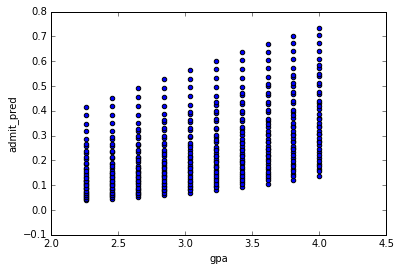

In [274]:
#combos['admit_pred'].plot()
combos.plot.scatter(x='gpa', y='admit_pred')

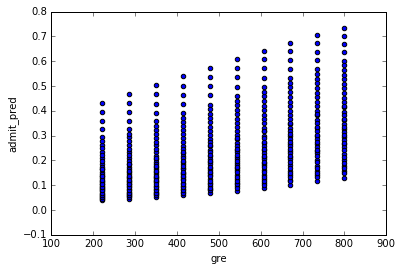

In [272]:
combos.plot.scatter(x='gre', y='admit_pred')


#### Performance Evaluation
Great work!

| Requirements | Incomplete (0) | Does Not Meet Expectations (1) | Meets Expectations (2) | Exceeds Expectations (3) |
|---|---|---|---|---|
| Create dummy variables | | |X | |
| Calculate OR by hand | | |X | |
| Complete a logistic regression using stats models and interpret your findings | | | X| |
| Calculate predicted probabilities | | |X | |